# О чем говорят любители рэпа?
# Часть 3: Визуализация данных

In [6]:
import pandas as pd              # Пакет для работы с таблицами
import numpy as np               # Пакет для работы с векторами и матрицами
import matplotlib.pyplot as plt  # Пакет для строительства графиков
import seaborn as sns            # Еще один пакет для графиков
import datetime                  # Пакет для работы с временными форматами
import pickle                    # Пакет для подгрузки данных специфического для питона формата

from dateutil.relativedelta import relativedelta # еще один пакет для работы с временем
from wordcloud import WordCloud  # Пакет для построения облаков слов

plt.style.use('ggplot')          # задаём красивый стиль для графиков matplotlib-а
%matplotlib inline

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Топики

Визуализируем все 30 топиков, построенных по всему корпусу текста

In [9]:
with open('lda_30_topics_bigrams_long_comments', 'rb') as f:
    lda_30_topics = pickle.load(f)

In [10]:
def plotWordCloud(topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
    text = dict(lda_30_topics[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

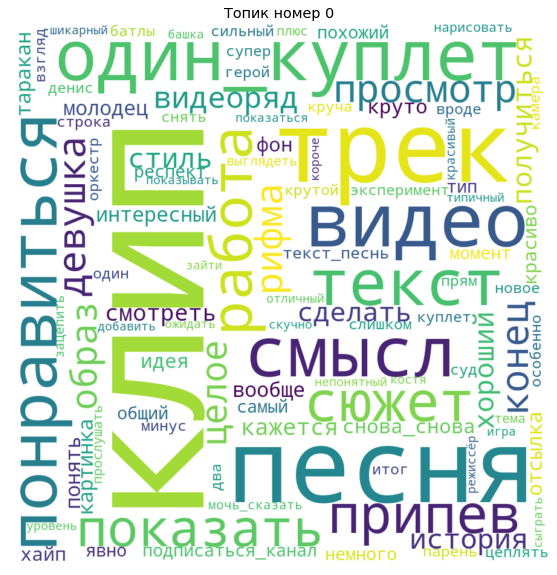

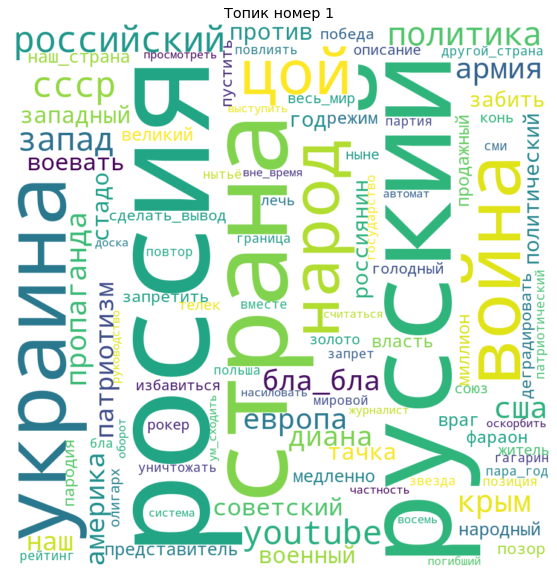

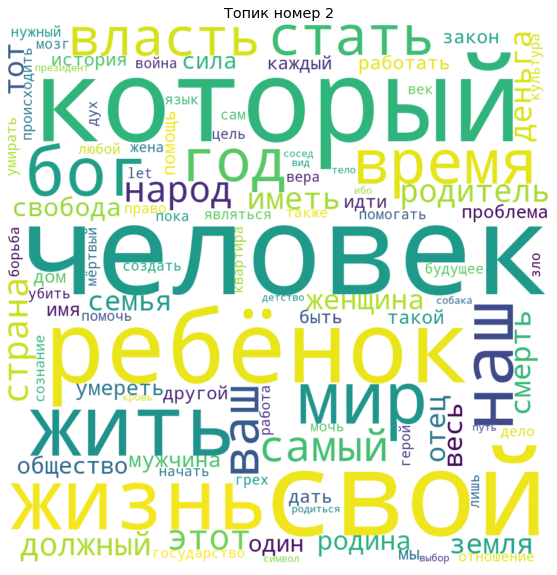

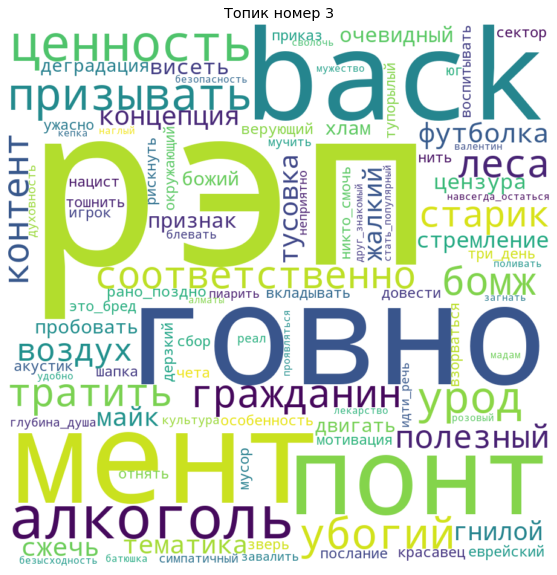

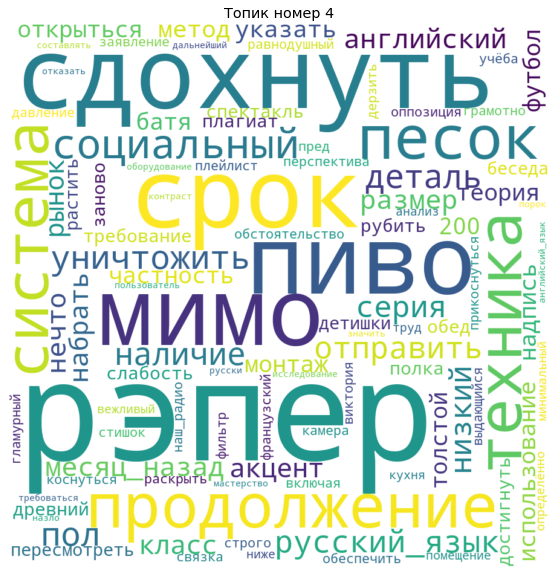

In [11]:
for i in range(5):
    plotWordCloud(topic_number=i)

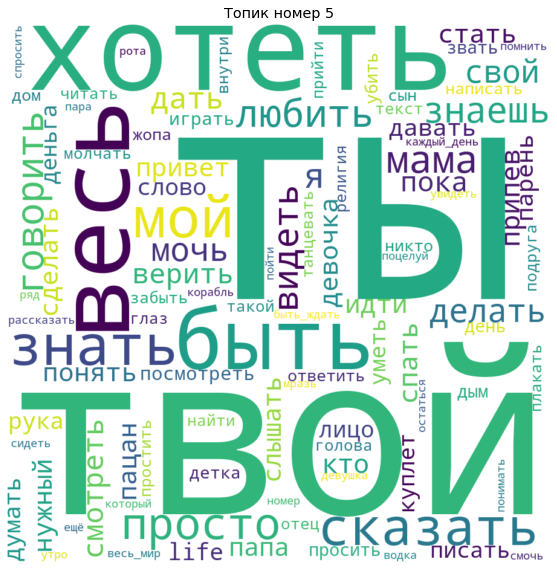

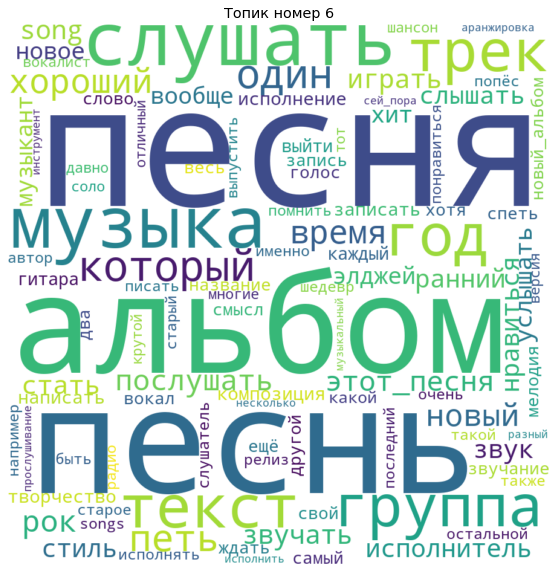

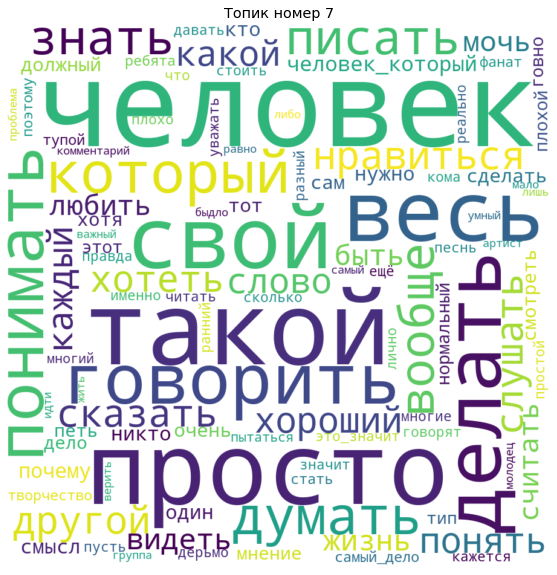

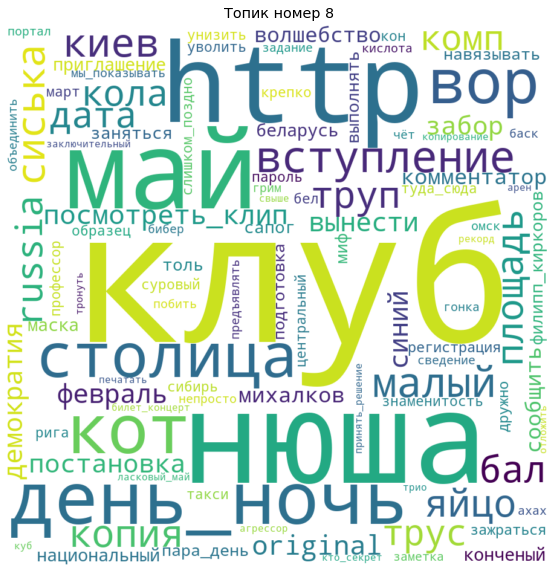

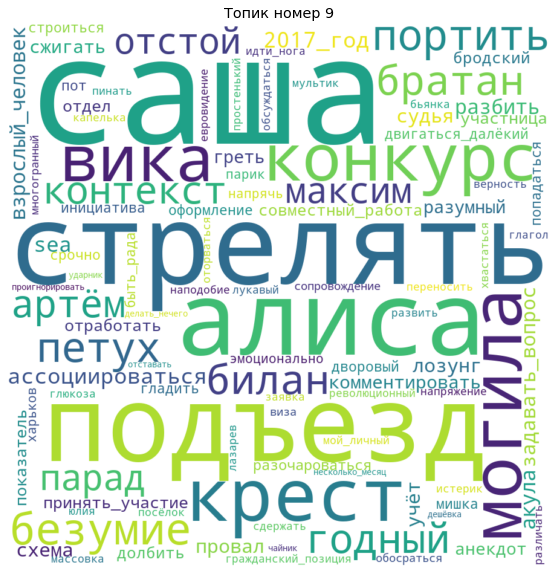

In [12]:
for i in range(5, 10):
    plotWordCloud(topic_number=i)

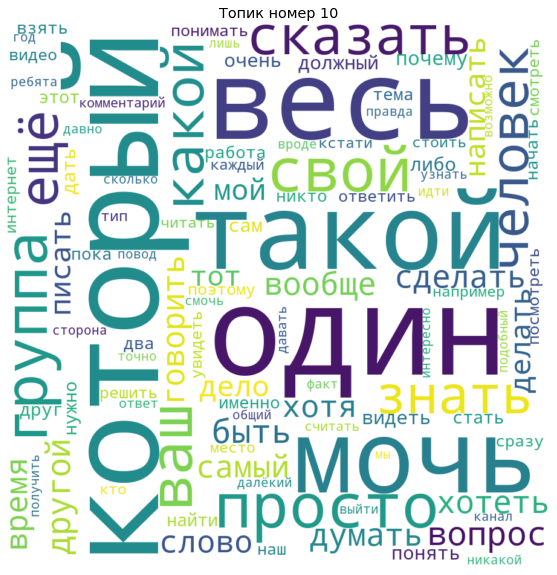

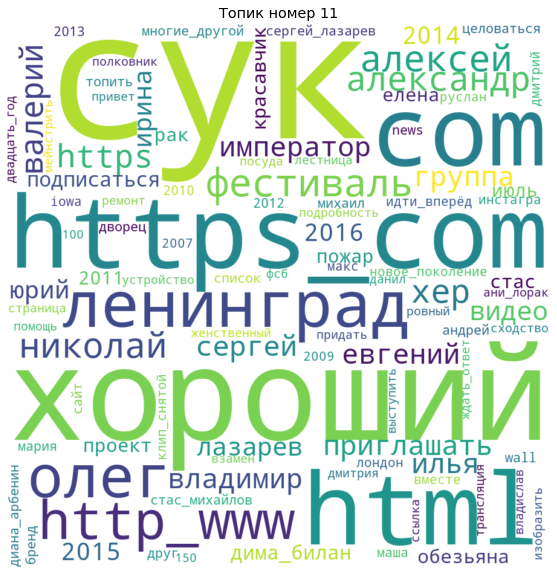

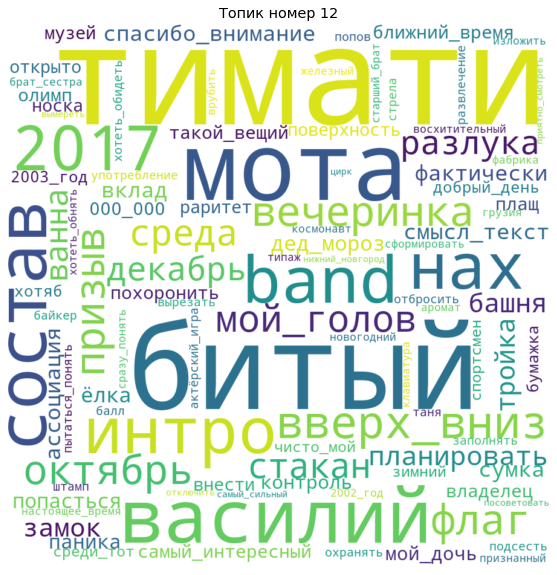

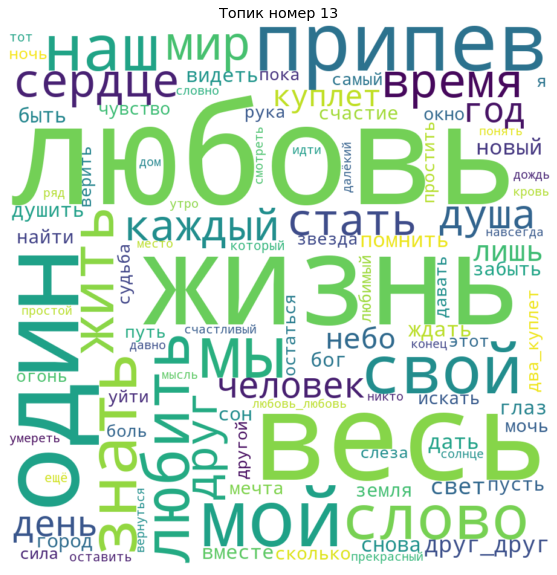

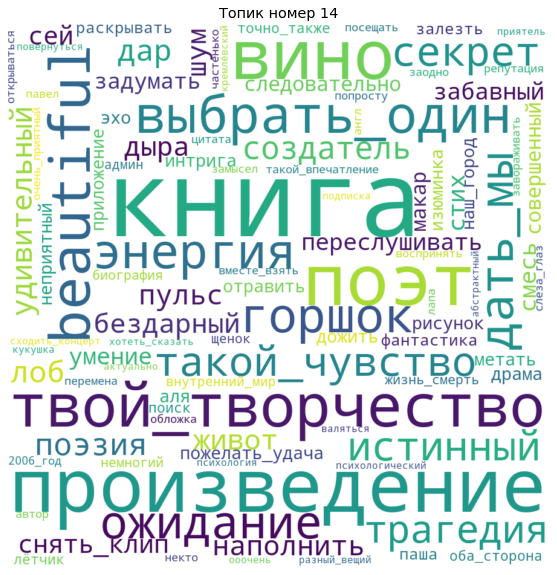

In [13]:
for i in range(10, 15):
    plotWordCloud(topic_number=i)

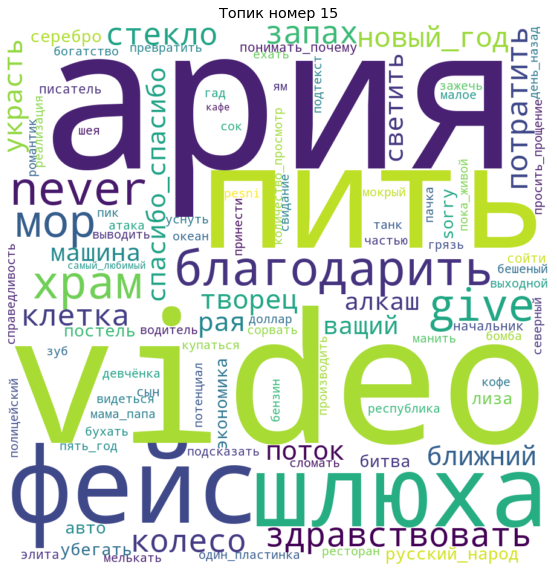

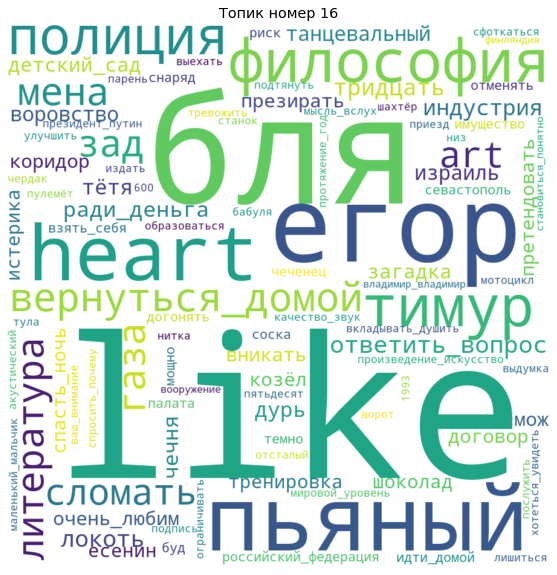

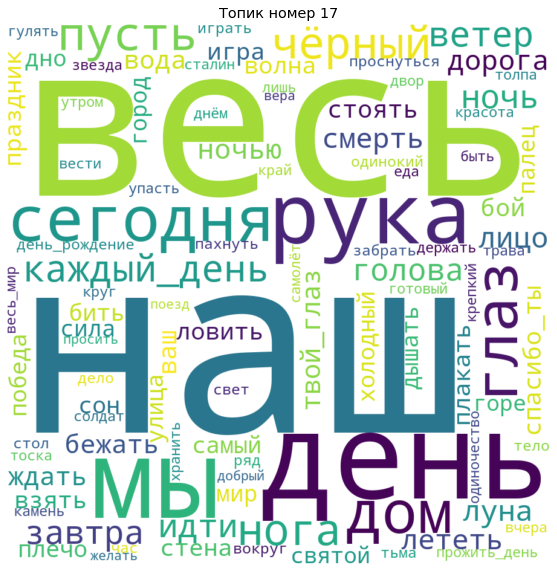

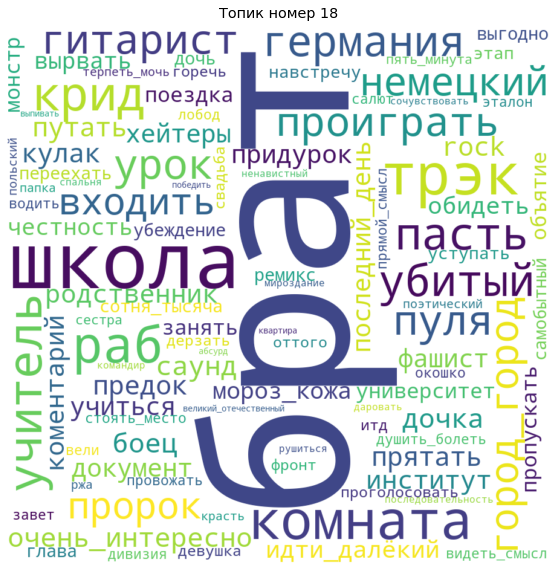

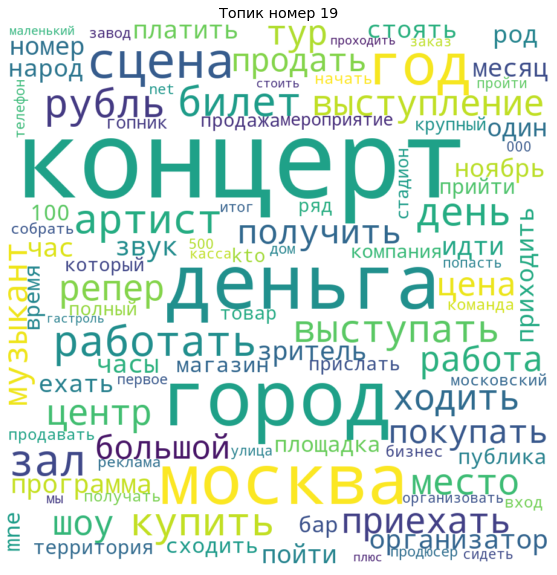

In [14]:
for i in range(15, 20):
    plotWordCloud(topic_number=i)

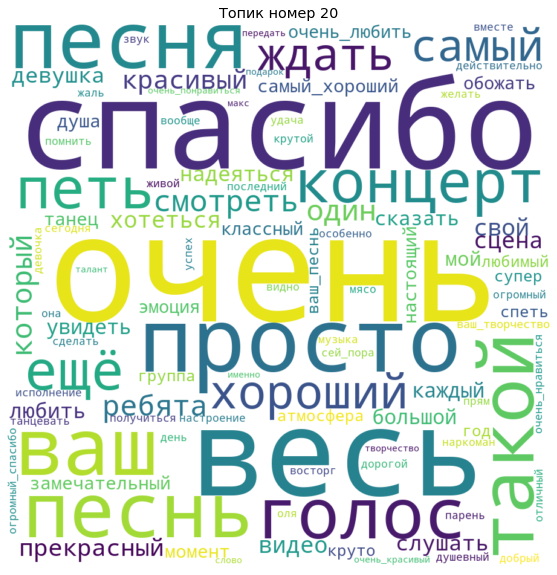

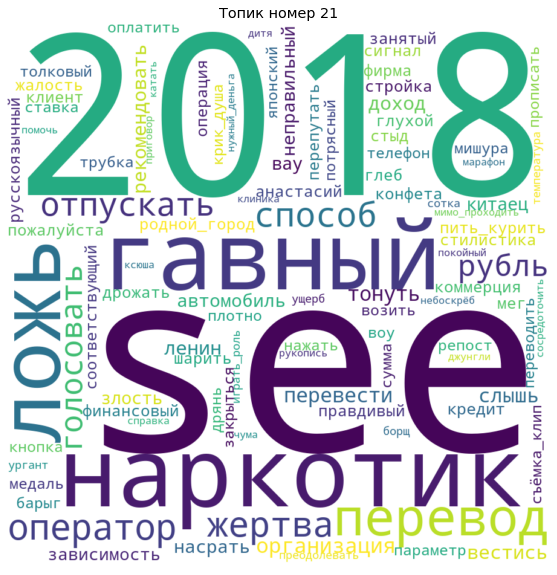

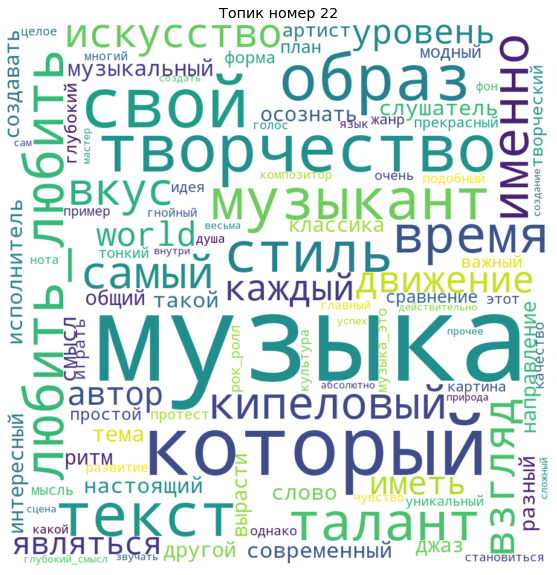

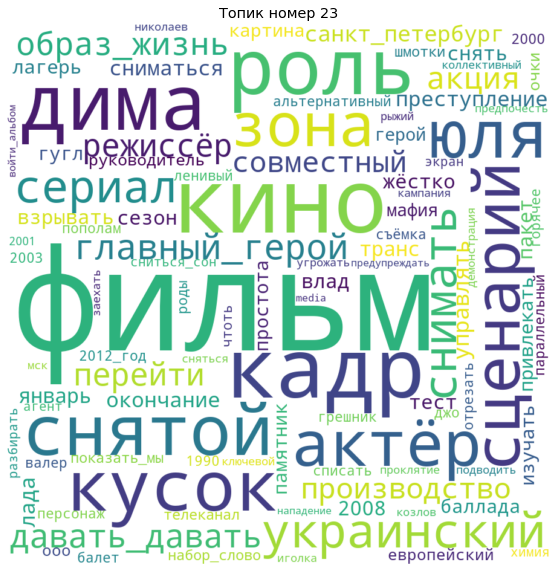

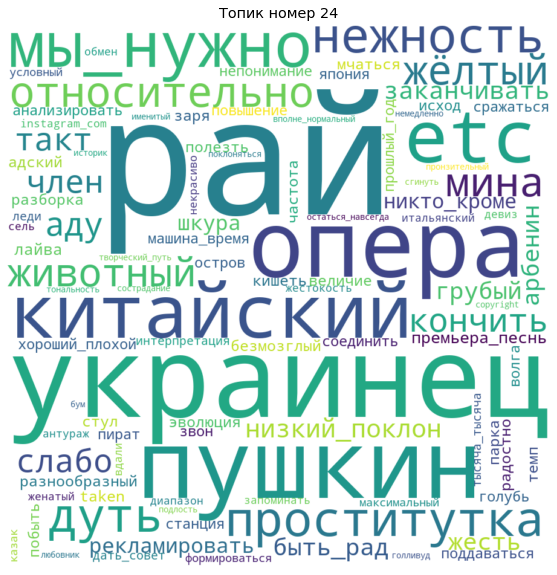

In [15]:
for i in range(20, 25):
    plotWordCloud(topic_number=i)

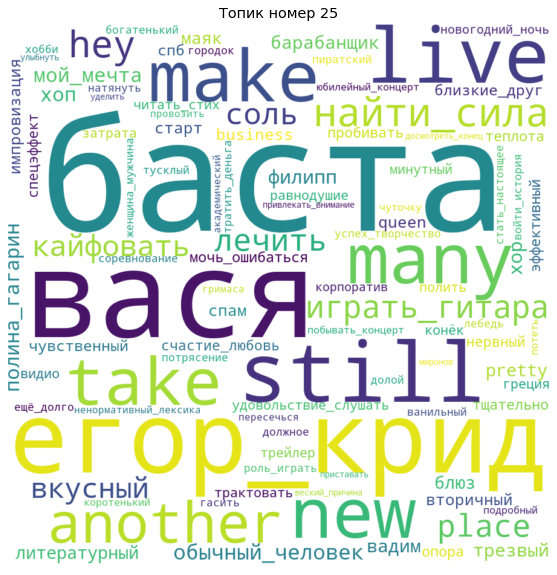

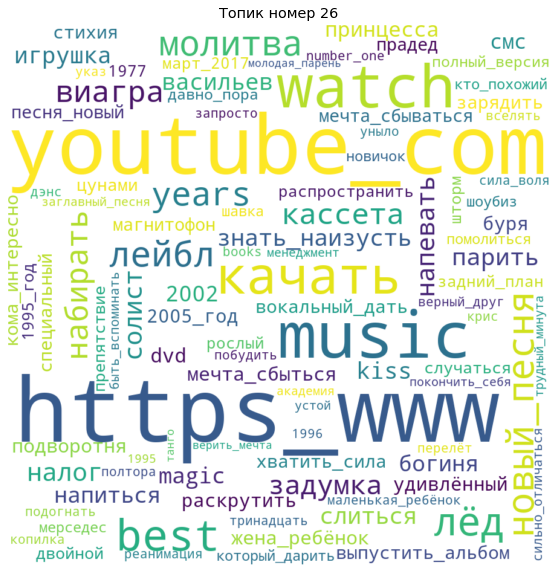

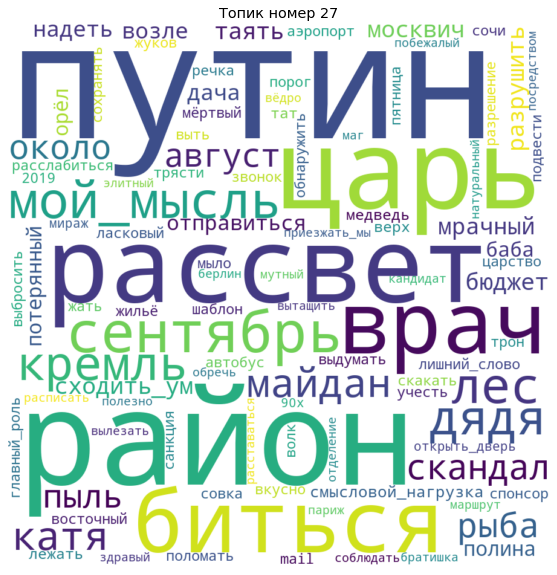

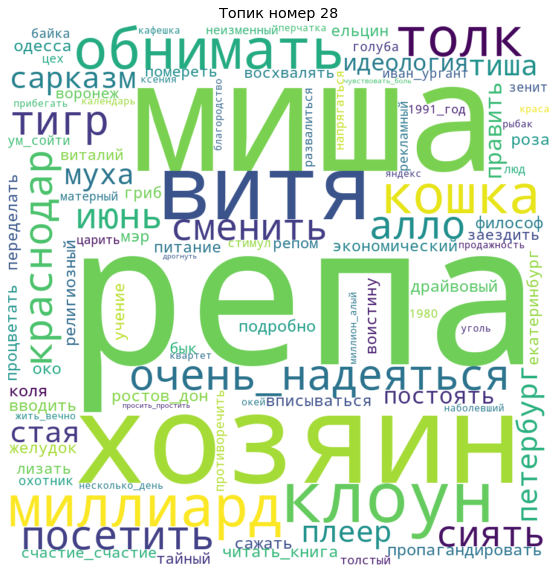

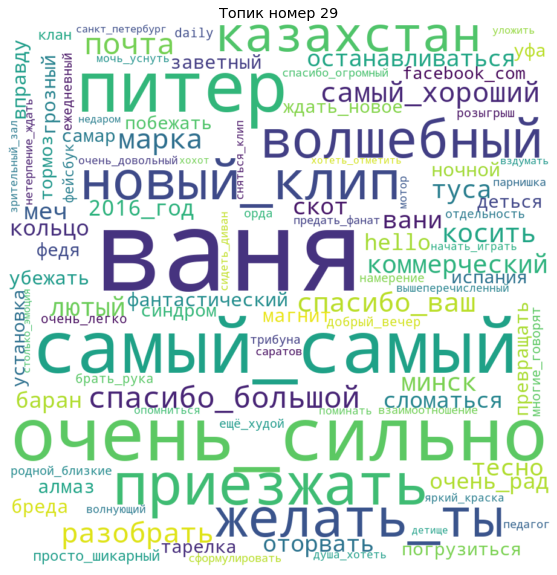

In [16]:
for i in range(25, 30):
    plotWordCloud(topic_number=i)

In [17]:
themes_30 = {
     0 : 'клипы на песни, видео',         1 : 'политика, Украина-Россия', 
     2 : 'общество и человек',            3 : 'рэп и говно',
     4 : 'социальные темы в рэпе',        5 : 'песни о любви',          
     6 : 'понравившиеся альбомы песен',   7 : 'человек, говорим, думаем и слушаем',
     8 : 'клубы и нюша',                  9 : 'тексты рок песен (АлисА)',       
     10: 'неинтерпретируемая',            11: 'веб-ссылки и старые песни',
     12: 'Тимати',                        13: 'песни о жизни и любви', 
     14: 'высокие темы: поэзия, творчество, книги',       15: 'Ария',
     16: 'новости и политика',                            17: 'тексты попсовых песен',           
     18: 'школа и её проблемы',                           19: 'покупка билетов на концерт',
     20: 'благодарности за концерт',                      21: 'денежные переводы',     
     22: 'глубоко обсуждаем музыку',                      23: 'фильмы и съемки кино',
     24: 'неинтерпретируемая',                            25: 'Баста и Егор Крид',   
     26: 'ссылки на YouTube',                             27: 'Путин, царь и политика',
     28: 'неинтерпретируемая',                            29: 'куча позитива и благодарностей' 
}

In [19]:
with open('ldamodel_30_bigrams_long_comments', 'rb') as f:
    ldamodel_30 = pickle.load(f)

In [20]:
with open('corpus', 'rb') as f:
    corpus = pickle.load(f)

In [21]:
expElogbeta = np.load("ldamodel_30_bigrams_long_comments.expElogbeta.npy")
ldamodel_30.expElogbeta = expElogbeta

In [22]:
from tqdm import tqdm_notebook

In [23]:
def topicProfileGenre(model, music_style, dataset, corpus, genre=True):

    # Тут будем хранить результат
    theme_results = [ ]

    # Какое в модели количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соовтетствуют текущему жанру
    if genre:
        num = dataset[dataset.music_style == music_style].index.get_values() 
    else:
        num = dataset[dataset.performer == music_style].index.get_values() 

    # Вектор для тематического профиля жанра
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем любителям текущего жанра
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    #print('Доля битых профилей для {}:'.format(music_style), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

In [24]:
data_reduced = pd.read_csv("../data/reduced_comments.csv")
data_reduced = data_reduced[data_reduced['comment_len']>40]
data_reduced.reset_index(inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/reduced_comments.csv'

In [ ]:
music_style_themes = { }
for music_style in tqdm_notebook(data_reduced.music_style.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_30, music_style, data_reduced, corpus)
    
    # Записываем их в словарик:
    music_style_themes[music_style] = theme

In [ ]:
performer_themes = { }
for performer in tqdm_notebook(data_reduced.performer.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_30, performer, data_reduced, corpus, genre=False)
    
    # Записываем их в словарик:
    performer_themes[performer] = theme

In [ ]:
# Сохраняем словарик с тематическими профилями 
with open('performer_themes', 'wb') as f:
    pickle.dump(performer_themes, f)

In [ ]:
# Сохраняем словарик с тематическими профилями 
with open('music_style_themes', 'wb') as f:
    pickle.dump(music_style_themes, f)

In [ ]:
# Читаем словарик с тематическими профилями 
with open('music_style_themes', 'rb') as f:
    music_style_themes = pickle.load(f)
    
with open('performer_themes', 'rb') as f:
    performer_themes = pickle.load(f)

In [ ]:
def profilePlot(theme_profile, music_style, themes=themes_30):
    """
    Строит тематическией профиль для каждого жанра
    theme_profile:
        тематический профиль, dict
    music_style: 
        стиль музыки
    themes dict:
        названия тем
    """
    
    theme_profile = theme_profile[music_style]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(30, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Тематический профиль для {}: \n'.format(music_style))
    plt.show()
    

In [ ]:
for music_style in data_reduced.music_style.unique():
    profilePlot(music_style_themes, music_style)

# Интерактив

In [ ]:
def get_interpretable_topics(topics, interpretation):
    topics_clean = {}
    
    for key, value in topics.items():
        clean_topics = []
        clean_probs = []
        for topic, prob in value:
            if themes_30[topic]!="неинтерпретируемая":
                clean_topics.append(topic)
                clean_probs.append(prob)

        clean_probs = np.array(clean_probs)/np.sum(clean_probs)

        topics_clean[key] = list(zip(clean_topics, clean_probs))
        
    return topics_clean

In [ ]:
music_style_themes_clean = get_interpretable_topics(music_style_themes, themes_30)
performer_themes_clean = get_interpretable_topics(performer_themes, themes_30)

In [ ]:
profilePlot(performer_themes_clean, 'киркоров')

In [ ]:
profilePlot(performer_themes, 'киркоров')

In [ ]:
profilePlot(performer_themes_clean, 'монеточка')

In [ ]:
profilePlot(performer_themes_clean, 'noizemc')

In [ ]:
profilePlot(performer_themes_clean, 'тимати')

## 5. Близость любителей разных жанров

In [ ]:
from scipy.spatial.distance import cosine
music_style = list(music_style_themes_clean.keys())
n = len(music_style)  # выясняем число жанров
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in music_style_themes_clean[music_style[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in music_style_themes_clean[music_style[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние
            
sns.set(font_scale=1.5)
plt.subplots(figsize=(8, 8))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=music_style, xticklabels=music_style,cbar=False);

In [ ]:
performers = list(performer_themes_clean.keys())
n = len(performers)  # выясняем число исполнителей
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in performer_themes_clean[performers[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in performer_themes_clean[performers[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние

In [ ]:
performers_distances = pd.DataFrame(R, columns=performers, index=performers)

In [ ]:
performers_distances.head()

In [ ]:
def plotMostSimilarDifferent(performer, distances=performers_distances):
    """
        Строит график с самыми похожими и непохожими по косинусной мере исполнителями
    """
    slice_most_similar = performers_distances.nsmallest(
        11, [performer])[[performer]].iloc[1:]
    slice_most_different = performers_distances.nlargest(
        10, [performer])[[performer]].sort_values(by=performer)
    
    result = pd.concat([slice_most_similar, slice_most_different])
    
    plt.figure(figsize=(20, 30))
    ax = plt.axes() 
    sns.heatmap(result.values.reshape(1, 20), ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                     cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=result.index)
    ax.set_title('{}: топ-10 похожих и непохожих\n'.format(performer).capitalize())
    plt.show()

# Так кто же на кого похож? 

In [ ]:
plotMostSimilarDifferent('киркоров')

In [ ]:
plotMostSimilarDifferent('тимати')

In [ ]:
plotMostSimilarDifferent('лсп')

In [ ]:
plotMostSimilarDifferent('король_и_шут')

## t-SNE

In [ ]:
music_style_themes_clusters = {}
for k, v in music_style_themes_clean.items():
    music_style_themes_clusters[k] = [prob[1] for prob in v]
    
music_style_themes_clusters = pd.DataFrame(music_style_themes_clusters).T

In [ ]:
from MulticoreTSNE import MulticoreTSNE

In [ ]:
tsne = MulticoreTSNE()
tsne_features = tsne.fit_transform(music_style_themes_clusters)

In [ ]:
# Create a trace
trace = go.Scatter(
    x = tsne_features[:, 0],
    y = tsne_features[:, 1],
    mode = 'markers+text',
    text = music_style_themes_clusters.index,
    textposition='top center'
)

data = [trace]

layout = go.Layout(
    autosize=False,
    width=700,
    height=700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='size-margins')

In [ ]:
performer_themes_clusters = {}
for k, v in performer_themes_clean.items():
    performer_themes_clusters[k] = [prob[1] for prob in v]
    
performer_themes_clusters = pd.DataFrame(performer_themes_clusters).T

In [ ]:
tsne = MulticoreTSNE(perplexity=5)
tsne_features = tsne.fit_transform(performer_themes_clusters)

In [ ]:
kmeanModel = KMeans(n_clusters=len(music_style_themes.keys())).fit(tsne_features)

In [ ]:
import plotly 
plotly.tools.set_credentials_file(username='DmitrySerg', api_key='0VfXedE7AtqjhfirqFkj')

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
# Create a trace
trace = go.Scatter(
    x = tsne_features[:, 0],
    y = tsne_features[:, 1],
    mode = 'markers+text',
    text = performer_themes_clusters.index,
    textfont=dict(
        size=11,
    ),
    textposition='top center',
    marker = dict(
        color=kmeanModel.predict(tsne_features),
        size = 8,
        colorscale='Jet'
    )
)

data = [trace]

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='performers t-SNE')